In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import lightgbm  as lgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load the breast cancer dataset from sklearn
data = load_breast_cancer()
X, y = data.data, data.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss'
}

# Train the LightGBM model
model = lgb.train(params, train_data)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the predicted probabilities
print(predictions)


: 

: 

In [2]:
# !pip install meteostat

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
# from meteostat import Hourly,Point
from sklearn.metrics import mean_absolute_percentage_error


# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

# Data Preprocess

In [18]:
uebb = '/Users/ata/Desktop/tüb_dersler/mlses/UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df = df.reset_index()

In [19]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected']
missing_fields_neighbor = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

max_min_norm = ['sonic_temperature','sonic_wind_speed','sonic_wind_direction',]

In [21]:
# fill NaN fields with t-1 values
for f in missing_fields_neighbor:
    df[f] = df[f].ffill()

#replace NaN values with mean for the rest
for f in missing_fields_neighbor:
    df[f] = df[f].fillna(df[f].mean())

#drop high empty fields
df = df.drop(columns=high_empty_fields)
df['Time'] = pd.to_datetime(df['Time'])

# sample with 3 freq 
sampled_df = df.iloc[::200,:]
sampled_df_h = df.iloc[::1200,:]

KeyError: "['wind_direction_std', 'air_temperature', 'relative_humidity', 'UST', 'UST_flag', 'HS', 'HS_flag', 'TKE', 'LMO', 'ws_w_corrected'] not found in axis"

# Utils

In [22]:
def model_summarizer(model,predictions,targets,plot_steps = 100,exp_title='',feat = True):
    train_pred,val_pred,test_pred = predictions.items()
    train_y,val_y,test_y = targets.items()
    
    score,mape, rmse,R2 = score_function(test_y[1],test_pred[1])
    print(f'Mix score: {score}, MAPE: {mape}, RMSE: {rmse}, R2: {R2}')
    
    plt.figure(figsize=(10,10))
    index = np.arange(val_y[1].shape[0])
    plt.plot(index[:plot_steps],val_y[1][:plot_steps], label = 'Y')
    plt.plot(index[:plot_steps],val_pred[1][:plot_steps], label= 'Pred')
    plt.legend()
    plt.title(f'{exp_title} prediction val')
    
    plt.figure(figsize=(10,10))
    index = np.arange(test_y[1].shape[0])
    plt.plot(index[:plot_steps],test_y[1][:plot_steps], label = 'Y')
    plt.plot(index[:plot_steps],test_pred[1][:plot_steps], label= 'Pred')
    plt.legend()
    plt.title(f'{exp_title} step prediction Test')
    # plt.plot(test_preds.yhat,label = ' Y_hat')
    
    if feat:
        feature_importance = model.get_feature_importance()

        # Get the names of the features
        feature_names = X.columns

        # Create a bar plot of feature importance
        plt.figure(figsize=(10, 8))
        plt.bar(feature_names, feature_importance)
        plt.xticks(rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title(f'Feature Importance {exp_title}')
    plt.tight_layout()
    plt.show()


In [8]:
class Dataset:
    """
    A class that represents a dataset and provides methods for data preprocessing and feature engineering.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the dataset.

    Methods:
        create_y(df: pd.DataFrame, delay: int) -> pd.DataFrame:
            Creates a lagged target variable DataFrame.

        apply_rolling_window(df: pd.DataFrame, data: str, roll_time: int, window_function: callable):
            Applies a rolling window function to a specific column of the DataFrame.

        add_last_t(df: pd.DataFrame, data: str, step: int = 2):
            Adds the last T steps of a specific column as new features to the DataFrame.

        add_seasonal_feat(df: pd.DataFrame):
            Adds seasonal features based on time information to the DataFrame.

        create_dataset(delay: int, roll_time: int, rolling_features: list = []) -> pd.DataFrame:
            Creates the final dataset with lagged features, rolling window features, and additional features.
    """
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
   
    def create_y(self, df: pd.DataFrame, delay: int) -> pd.DataFrame:
        """
        Create a lagged target variable DataFrame.

        Parameters:
            df (pd.DataFrame): The input DataFrame.
            delay (int): The number of time steps to lag the data.

        Returns:
            pd.DataFrame: The DataFrame with the lagged target variable.
        """
        y = pd.DataFrame()
        y['y'] = df.shift(-delay)
        y.dropna(inplace=True)
        return y
   
    def apply_rolling_window(self, df: pd.DataFrame, data: str, roll_time: int, window_function: callable):
        """
        Applies a rolling window function to a specific column of the DataFrame.

        Parameters:
            df (pd.DataFrame): The input DataFrame.
            data (str): The column name on which to apply the rolling window function.
            roll_time (int): The window size for the rolling window function.
            window_function (callable): The function to apply on the rolling window.

        Returns:
            pd.DataFrame: The DataFrame with the applied rolling window function.
        """
        if not callable(window_function):
            raise ValueError("window_function must be a callable function")

        df[f'rolling_{window_function.__name__}_{data}'] = df[data].rolling(window=roll_time).apply(window_function)
        df.fillna(0, inplace=True)
        return df
         
    def add_last_t(self, df: pd.DataFrame, data: str, step: int = 2):
        """
        Adds the last T steps of a specific column as new features to the DataFrame.

        Parameters:
            df (pd.DataFrame): The input DataFrame.
            data (str): The column name for which to add the last T steps as new features.
            step (int): The number of steps to consider.

        Returns:
            None
        """
        for i in range(1, step+1):
            df[f'{data}_last_{i}_step'] = df[data].shift(i)
            df[f'{data}_last_{i}_step'].fillna(0)

    def add_seasonal_feat(self, df: pd.DataFrame):
        """
        Adds seasonal features based on time information to the DataFrame.

        Parameters:
            df (pd.DataFrame): The input DataFrame.

        Returns:
            None
        """
        df['hour_sin'] = np.sin(df.Time.dt.hour / 23 * 2 * np.pi)
        df['hour_cos'] = np.cos(df.Time.dt.hour / 23 * 2 * np.pi)
        df['week_sin'] = np.sin((df.Time.dt.week / 52) * 2 * np.pi)
        df['week_cos'] = np.cos((df.Time.dt.week / 52) * 2 * np.pi)

    def create_dataset(self, delay: int, roll_time: int, rolling_features: list = []) -> pd.DataFrame:
        """
        Creates the final dataset with lagged features, rolling window features, and additional features.

        Parameters:
            delay (int): The number of time steps to lag the target variable.
            roll_time (int): The window size for the rolling window features.
            rolling_features (list): A list of column names on which to apply the rolling window features.

        Returns:
            pd.DataFrame: The final dataset with all the engineered features.
        """
        X = self.df.copy()
        y = self.create_y(X, delay)
        X = X.dropna(subset=['y'])
        X = X.ffill()



        for f in rolling_features:
            self.apply_rolling_window(X, f, roll_time, np.mean)
            self.apply_rolling_window(X, f, roll_time, np.std)
            self.apply_rolling_window(X, f, roll_time, np.min)
            self.apply_rolling_window(X, f, roll_time, np.max)
            self.apply_rolling_window(X, f, roll_time, np.median)
      
        if delay < 20:
            self.add_last_t(X, 'active_power_total', step=2)
        
        return X,y
   

In [23]:
def add_seasonal_feat(df):
    # Add sine and cosine features to represent time of day and time of year
    df['hour_sin'] = np.sin(df.Time.dt.hour / 23 * 2 * np.pi)
    df['hour_cos'] = np.cos(df.Time.dt.hour / 23 * 2 * np.pi)
    df['week_sin'] = np.sin((df.Time.dt.week / 52) * 2 * np.pi)
    df['week_cos'] = np.cos((df.Time.dt.week / 52) * 2 * np.pi)
    
def add_weather_forecast(df,delay):
    noise = np.random.normal(loc=0, scale=0.5, size=len(df)) ## TODO replace this with real forecast
    df['last_sonic_temperature']= (df['sonic_temperature']+noise).shift(delay).fillna(0)
    df['last_sonic_wind_speed']= (df['sonic_wind_speed'] + noise).shift(delay).fillna(0)
    df['last_air_pressure']= (df['air_pressure'] + noise).shift(delay).fillna(0)

In [24]:
def create_y(data,delay):
    """
    Create lagged features for a given time series dataset.

    Args:
    - data: pandas DataFrame with a single column representing the time series data
    - delay: time steps to predict

    Returns:
    - lagged_features: pandas DataFrame with the original data and lagged features
    """
 
    # Create a DataFrame to store the lagged features
    lagged_features = pd.DataFrame()

    # Lag the data by delay
    lagged_features['y'] = data.shift(-delay)
    
    # Drop the rows with NaN values
    lagged_features.dropna(inplace=True)

    return lagged_features

def create_rolling_mean(df,data,roll_time):
    df[f'rolling_mean_{data}'] = df[data].rolling(window=roll_time).mean()
    df[f'rolling_mean_{data}'] = df[f'rolling_mean_{data}'].fillna(0)
def create_rolling_min(df,data,roll_time):
    df[f'rolling_min_{data}'] = df[data].rolling(window=roll_time).min()
    df[f'rolling_min_{data}'] = df[f'rolling_min_{data}'].fillna(0)
def create_rolling_max(df,data,roll_time):
    df[f'rolling_max_{data}'] = df[data].rolling(window=roll_time).max()
    df[f'rolling_max_{data}'] = df[f'rolling_max_{data}'].fillna(0)
    
def add_last_t(df,data,step=2):
    for i in range(1, step+1):
        df[f'{data}_last_{i}_step'] = df[data].shift(i)
        df[f'{data}_last_{i}_step'].fillna(0)
    
def score_function(true_values, predicted_values):
    """
    Calculate a score to evaluate the performance of a time series prediction model.
    
    Parameters:
    true_values (numpy.ndarray): Array of true values for the time series.
    predicted_values (numpy.ndarray): Array of predicted values for the time series.
    
    Returns:
    float: Score representing the performance of the prediction model.
    """
    # Calculate the mean absolute percentage error (MAPE)
    mape = mean_absolute_percentage_error(true_values,predicted_values)
    
    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))

    R2 = r2_score(true_values, predicted_values)
    
    # Calculate the score as a combination of MAPE and RMSE
    score = 0.6 * mape + 0.4 * rmse
    
    return score,mape, rmse, R2

# Data Generation

In [25]:
final_1_df = sampled_df
final_h_df = sampled_df_h
# final_d_df = sampled_df

# 1 step
final_1_df['y'] = create_y(sampled_df.active_power_total,1)['y'] # 200 step delay corresponds to 10 min
final_1_df =final_1_df.dropna(subset=['y'])  # drop last T steps 
final_1_df = final_1_df.ffill()
# drop columns
final_1_df = final_1_df.drop(columns=['battery_V'])
# add_weather_forecast(final_1_df,1)

create_rolling_mean(final_1_df,'active_power_total',20)
# create_rolling_min(final_1_df,'active_power_total',10)
# create_rolling_max(final_1_df,'active_power_total',10)
create_rolling_mean(final_1_df,'sonic_wind_speed',20)
add_last_t(final_1_df,'active_power_total',5)
add_last_t(final_1_df,'sonic_wind_speed',5)
add_seasonal_feat(final_1_df)



# 1 hour
final_h_df['y'] = create_y(sampled_df.active_power_total,1)['y'] # 5 step delay corresponds to 1 h
final_h_df =final_h_df.dropna(subset=['y'])  # drop last T steps 
final_h_df = final_h_df.ffill()
final_h_df = final_h_df.drop(columns=['battery_V','logger_temperature'])
add_weather_forecast(final_h_df,1)

create_rolling_mean(final_h_df,'active_power_total',20)
create_rolling_min(final_h_df,'active_power_total',20)
# create_rolling_max(final_h_df,'active_power_total',20)
create_rolling_mean(final_h_df,'sonic_wind_speed',20)
add_last_t(final_h_df,'active_power_total',5)
add_last_t(final_h_df,'sonic_wind_speed',5)
add_seasonal_feat(final_h_df)


# 24 hour
final_d_df['y'] = create_y(sampled_df.active_power_total,1200*24)['y'] # 120 step delay corresponds to 1 d
final_d_df =final_d_df.dropna(subset=['y'])  # drop last T steps 
final_d_df = final_d_df.ffill()


/var/folders/rj/_z4vt33x5zs87kvwh7z9y05c0000gn/T/ipykernel_31546/3833772251.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_1_df['y'] = create_y(sampled_df.active_power_total,1)['y'] # 200 step delay corresponds to 10 min
/var/folders/rj/_z4vt33x5zs87kvwh7z9y05c0000gn/T/ipykernel_31546/4175017632.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_sin'] = np.sin((df.Time.dt.week / 52) * 2 * np.pi)
/var/folders/rj/_z4vt33x5zs87kvwh7z9y05c0000gn/T/ipykernel_31546/4175017632.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_cos'] = np.cos((df.Time.dt.week / 5

# Catboost Experiments

In [28]:
params = {'learning_rate': 0.01,
          'objective':'RMSE',
          'use_best_model': True,
          'thread_count':8,
          'iterations': 1000,
        # 'n_estimators':500,
           'max_depth': 10,
          }
def catboost_trainer(X,
                     y,
                     model_params,
                     test_split = 0.25,val_split = 0.25 ):
    """
    Catboost Trainer.
    
    ---------
    :param X: training data
    :param y: target
    :param model_params: dict of catboost model parameters
    :returns models and submission predictions 
    """
    
    score_list = []
    importance = []
    models = []
    predictions = {}
    targets = {}
    
    train_index = int(len(X) *( 1- test_split - val_split) )
    val_index = int(len(X) *( 1- test_split) )
  
    X_train,X_val,X_test = X.iloc[:train_index,:],X.iloc[train_index:val_index,:],X.iloc[val_index:,:]
    y_train,y_val,y_test = y.iloc[:train_index],y.iloc[train_index:val_index], y.iloc[val_index:]

    print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")



    model = CatBoostRegressor(**model_params)
    model.fit(X_train,y_train,
            eval_set=[(X_val,y_val)],
            verbose=500)
#     models.append(model)
#     forecast_pred = model.predict(sub_df_subset)
#     if target_transform:
#         forecast_pred = np.expm1(forecast_pred)
#     unseen_preds.append(forecast_pred)

    targets['train_y'] =y_train
    targets['val_y'] = y_val
    targets['test_y'] = y_test
    
    predictions['train_pred']= model.predict(X_train)
    predictions['val_pred'] = model.predict(X_val)
    predictions['test_pred']= model.predict(X_test)


    importance.append(model.get_feature_importance())

    
    return model,predictions,targets

## 1 Step Predictions

In [ ]:
X = final_1_df.drop(columns = ['y'])
y = final_1_df['y']
model, predictions,targets = catboost_trainer(X,y,params)

In [ ]:
model_summarizer(model,predictions,targets,exp_title = 'Next step',plot_steps =100)

# 1H Prediction

In [29]:
X = final_h_df.drop(columns = ['y'])
y = final_h_df['y']
model, predictions,targets = catboost_trainer(X,y,params)

Training data shape: (3504, 51), Validation data shape: (1752, 51)
0:	learn: 216.7231802	test: 272.9897519	best: 272.9897519 (0)	total: 117ms	remaining: 1m 56s
500:	learn: 63.8860888	test: 78.2749110	best: 78.2539728 (495)	total: 15.8s	remaining: 15.7s
999:	learn: 49.7940211	test: 77.6318796	best: 77.1568726 (681)	total: 30.6s	remaining: 0us

bestTest = 77.15687258
bestIteration = 681

Shrink model to first 682 iterations.


In [33]:
final_h_df[['y','active_power_total']]

,y,active_power_total
0,796.0,771.0
1200,761.0,758.0
2400,785.0,792.0
3600,371.0,785.0
4800,70.0,26.0
...,...,...
8403600,172.0,178.0
8404800,154.0,171.0
8406000,177.0,212.0
8407200,322.0,277.0


Mix score: 1.4165108863129512e+16, MAPE: 2.360851477188247e+16, RMSE: 75.37723528079671, R2: 0.8513041947301205


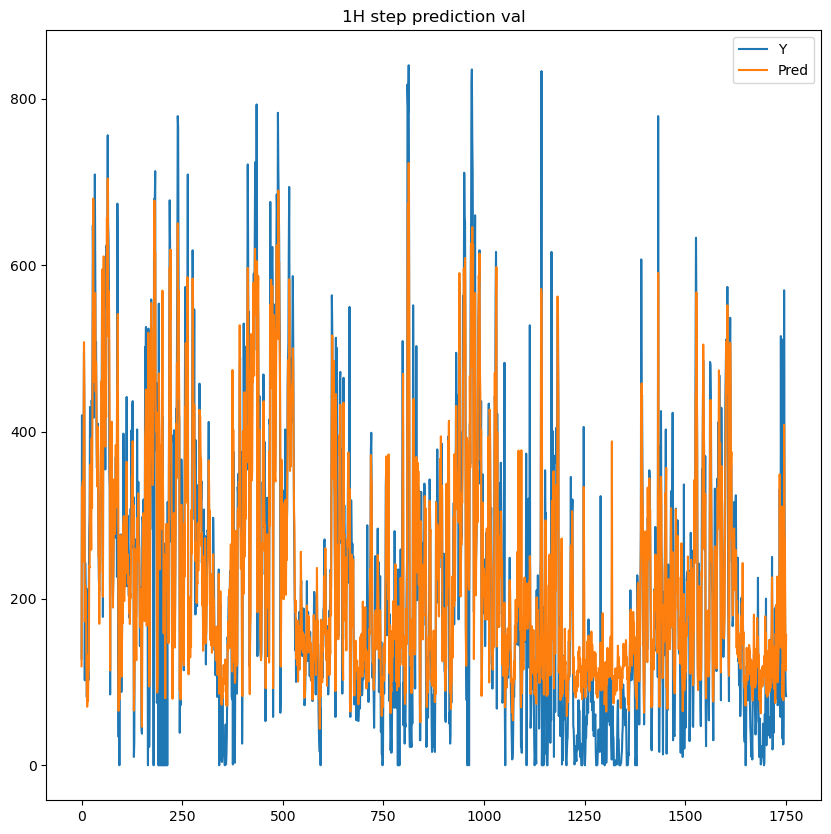

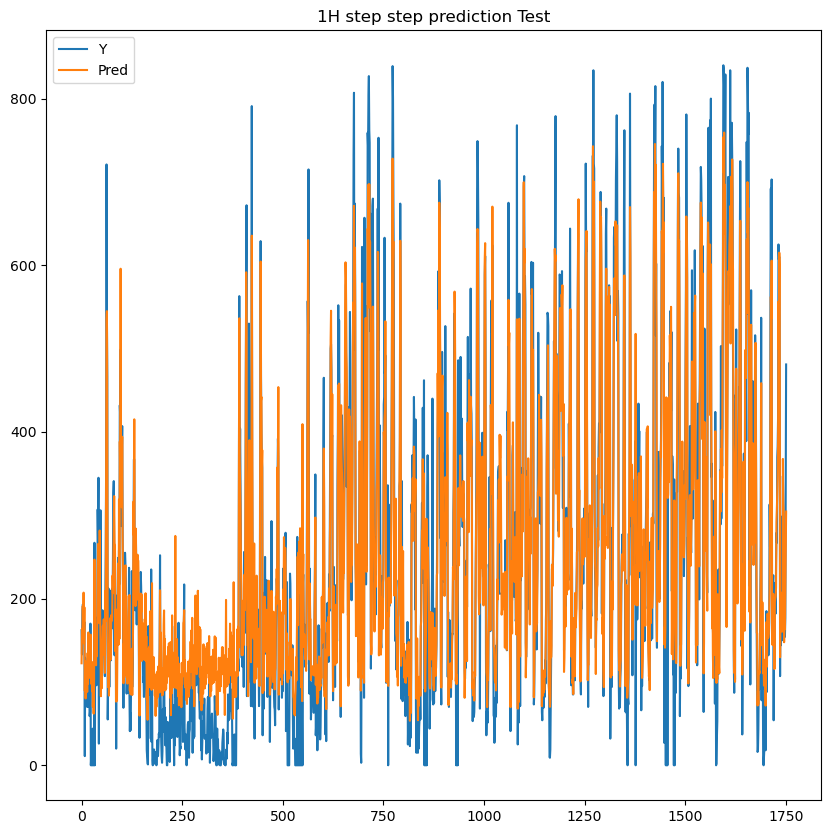

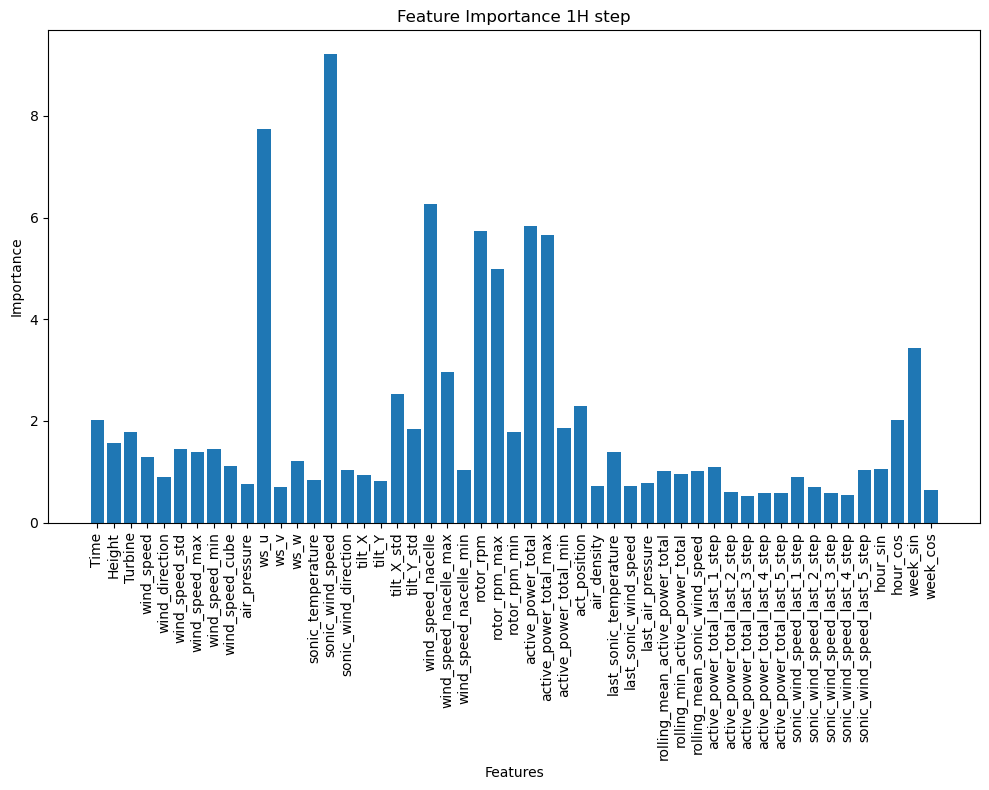

In [30]:
model_summarizer(model,predictions,targets,exp_title = '1H step',plot_steps = 10000)

## LIGHTGBM EXPERIMENTS

In [ ]:
params = {'learning_rate': 0.03,
          'objective':'RMSE',
          'use_best_model': True,
          'thread_count':24 #TODO
          }
def lgbm_trainer(X,
                     y,
                     model_params,
                     test_split = 0.25,val_split = 0.25 ):
    """
    Catboost Trainer.
    
    ---------
    :param X: training data
    :param y: target
    :param model_params: dict of catboost model parameters
    :returns models and submission predictions 
    """
    
    score_list = []
    importance = []
    models = []
    predictions = {}
    targets = {}
    
    train_index = int(len(X) *( 1- test_split - val_split) )
    val_index = int(len(X) *( 1- test_split) )
  
    X_train,X_val,X_test = X.iloc[:train_index,:],X.iloc[train_index:val_index,:],X.iloc[val_index:,:]
    y_train,y_val,y_test = y.iloc[:train_index],y.iloc[train_index:val_index], y.iloc[val_index:]

    print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")



    model = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,thread_count=24) #TODO
    model.fit(X_train,y_train,
            eval_set=[(X_val,y_val)],
            verbose=500)
#     models.append(model)
#     forecast_pred = model.predict(sub_df_subset)
#     if target_transform:
#         forecast_pred = np.expm1(forecast_pred)
#     unseen_preds.append(forecast_pred)

    targets['train_y'] =y_train
    targets['val_y'] = y_val
    targets['test_y'] = y_test
    
    predictions['train_pred']= model.predict(X_train)
    predictions['val_pred'] = model.predict(X_val)
    predictions['test_pred']= model.predict(X_test)


#     importance.append(model.feature_importance())

    
    return model,predictions,targets

In [ ]:
X = final_1_df.drop(columns = ['y', 'Time'])
y = final_1_df['y']
model, predictions,targets = lgbm_trainer(X,y,params)

In [ ]:
model_summarizer(model,predictions,targets,exp_title = 'Next step',plot_steps = 100,feat= False)

In [ ]:
    feature_importance = model.feature_importances_
    # Get the names of the features
    feature_names = X.columns

    # Create a bar plot of feature importance
    plt.figure(figsize=(10, 8))
    plt.bar(feature_names, feature_importance)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance')
    plt.tight_layout()
    plt.show()


## 1H LGBM

In [ ]:
X = final_h_df.drop(columns = ['y','Time'])
y = final_h_df['y']
model, predictions,targets = lgbm_trainer(X,y,params)

In [ ]:
model_summarizer(model,predictions,targets,exp_title = 'Next step',plot_steps = 100000,feat= False)

In [ ]:
    feature_importance = model.feature_importances_
    # Get the names of the features
    feature_names = X.columns

    # Create a bar plot of feature importance
    plt.figure(figsize=(10, 8))
    plt.bar(feature_names, feature_importance)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance')
    plt.tight_layout()
    plt.show()
